In [265]:
from sklearn.datasets import fetch_california_housing

In [266]:
X, y = fetch_california_housing(return_X_y=True)

In [267]:
data = fetch_california_housing(as_frame=True)

In [268]:
X = data["data"]
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [269]:
y = data["target"]
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [270]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel.experimental.optim as opt
import liesel.model as lsl
from liesel.experimental import nn

In [271]:
X_dict = X.to_dict("series")
X_dict = {k: jnp.asarray(v.to_numpy()) for k, v in X_dict.items()}

In [272]:
pos = {"y": jnp.asarray(y.to_numpy())} | X_dict
split = opt.Split.from_share(
    list(pos), n=X.shape[0], share_validate=0.2, share_test=0.1
)
split.indices = split.permute_indices(jax.random.key(42))
data = split.split_position(pos)

In [273]:
def std_y(y):
    train_mean = data.train["y"].mean()
    train_sd = data.train["y"].std()
    return (y - train_mean) / train_sd


pos["y"] = std_y(pos["y"])

data = split.split_position(pos)

In [274]:
batches = opt.Batches(list(pos), n=data.n_train, batch_size=128)
batches.indices = batches.permute_indices(jax.random.key(0))
b0 = batches.get_batched_position(data.train, 0)

In [275]:
features = []
for name in X_dict:
    if name not in ["Longitude", "Latitude"]:
        fn = jnp.log
    else:

        def fn(x):
            return x

    feat = nn.Feature.from_data(b0, data.train, name, standardize=True, fn=fn)
    features.append(feat)

In [276]:
calc = lsl.Calc(lambda *inputs: jnp.vstack(inputs).T, *features)
Xvar = lsl.Var(calc, name="X")

L1 = nn.DenseLayer(Xvar, size=32, activation_fn=jax.nn.relu)
L2 = nn.DenseLayer.from_layer(L1, size=32, activation_fn=jax.nn.relu)
loc = nn.Perceptron.from_layer(L2, name="loc")

log_scale = lsl.Var.new_param(jnp.log(10.0), name="log(scale)")
scale = lsl.Var.new_calc(jnp.exp, log_scale, name="scale")


yvar = lsl.Var.new_obs(
    value=b0["y"], distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale), name="y"
)

model = lsl.Model([yvar])


In [277]:
if L1.size < 6:
    model.plot_vars()

In [278]:
loss = opt.NegLogProbLoss(
    model=model,
    split=data,
    validation_strategy="log_lik",
)

In [279]:
import optax

In [280]:
scheduler = optax.cosine_decay_schedule(
    init_value=1e-4 * 5, decay_steps=1000 * batches.n_full_batches
)
opt_inst = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)
gradient_clipping = optax.clip_by_global_norm(1.0)
opt_chain = optax.chain(gradient_clipping, opt_inst)

optimizer = opt.Optimizer(
    list(model.parameters),
    optimizer=opt_chain,
)

In [281]:
engine = opt.OptimEngine(
    loss=loss,
    batching_indices=batches,
    data=data,
    stopper=opt.Stopper(max_iter=1000, patience=50, atol=0.0, rtol=1e-6),
    initial_state=model.state,
    optimizers=[optimizer],
    progress_n_updates=100,
    seed=1,
)

In [282]:
res = engine.fit()

Training loss: 9420.644, Validation loss: 10057.548:  48%|████▊     | 485/1000 [00:21<00:22, 23.04it/s] 


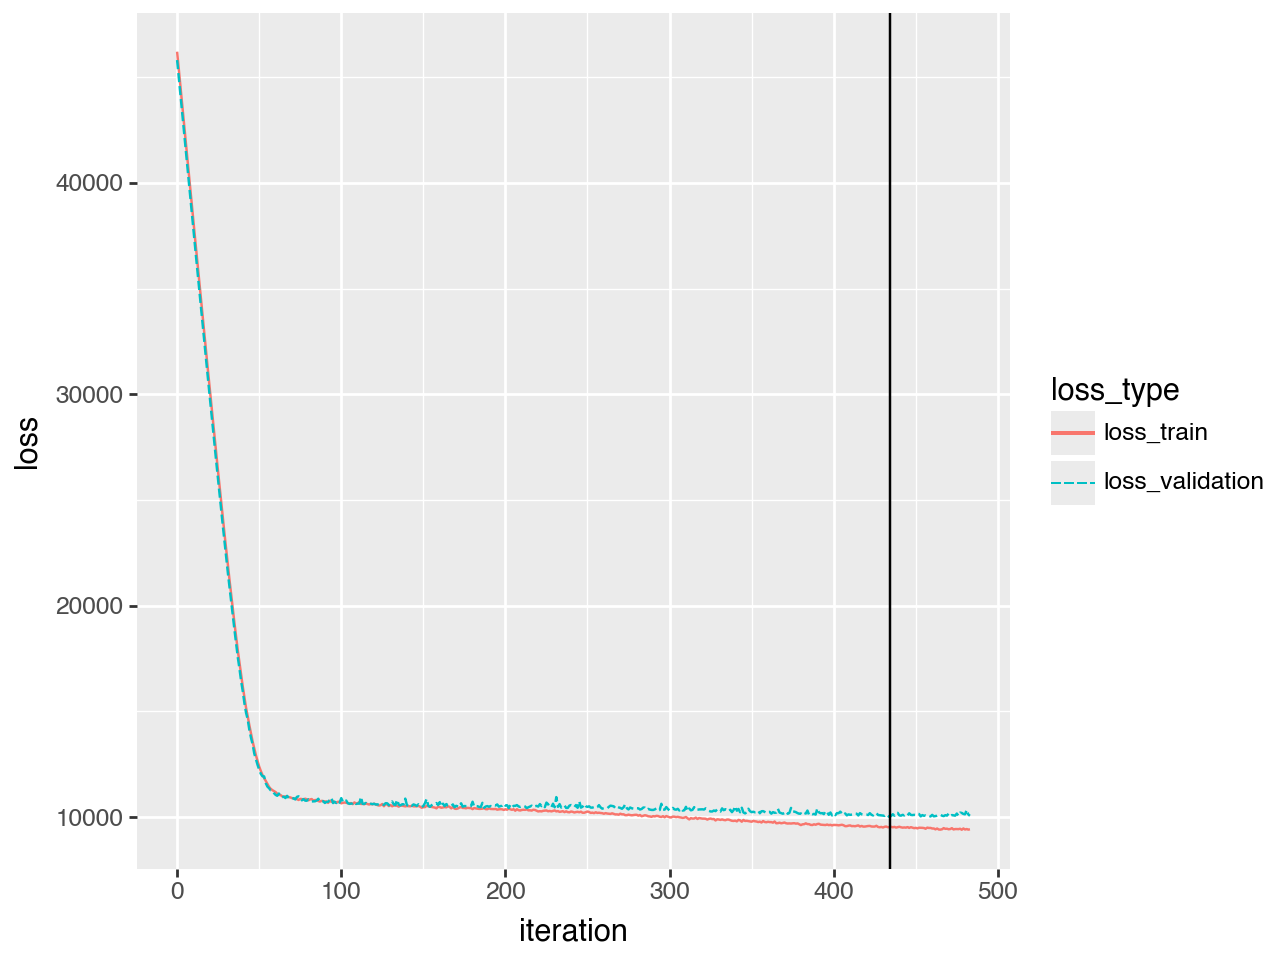

In [283]:
res.plot_loss()

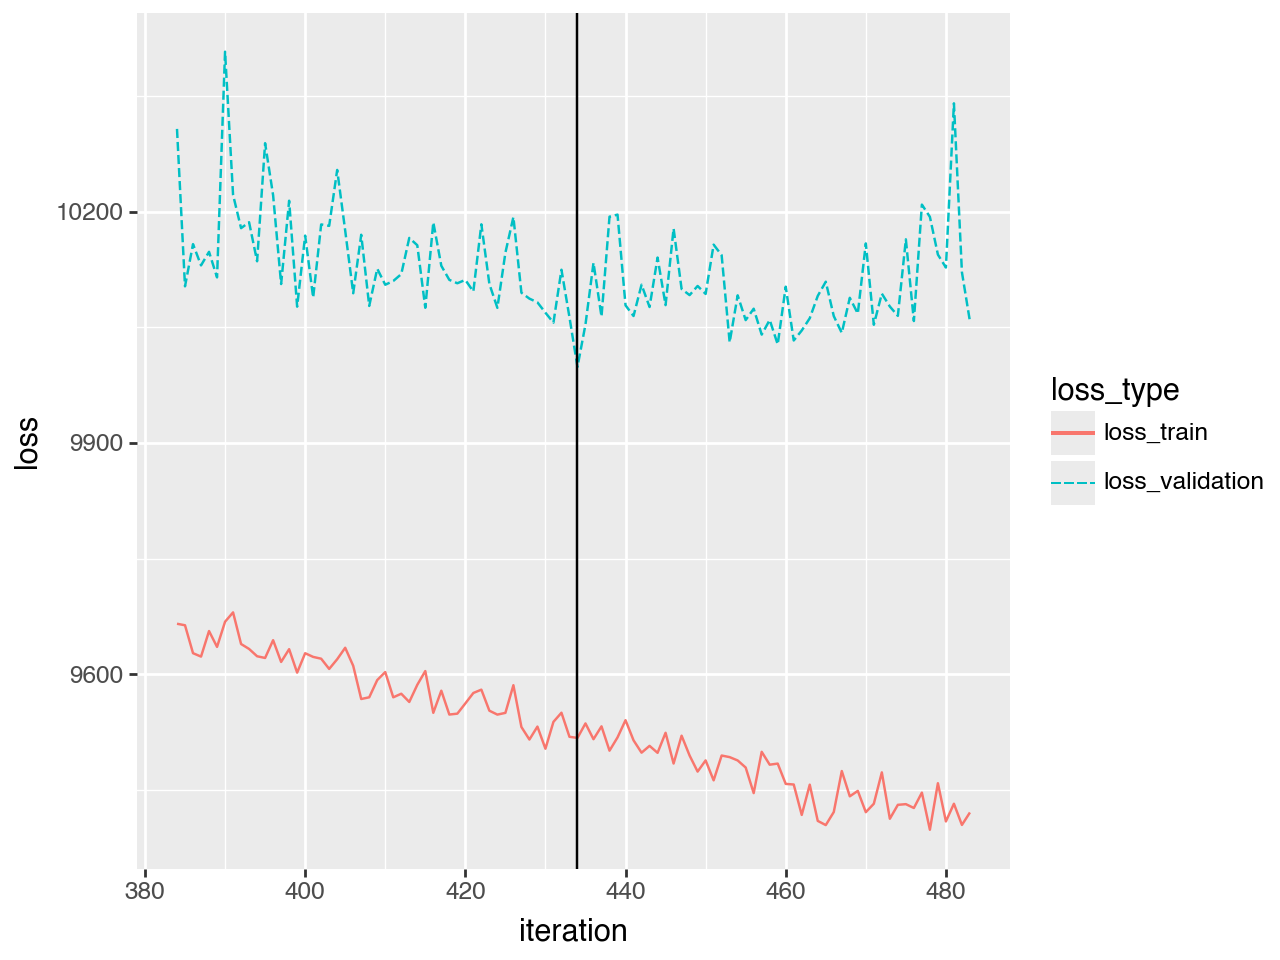

In [284]:
res.plot_loss(window=100)

In [285]:
samples = jax.tree.map(lambda x: jnp.expand_dims(x, (0, 1)), res.best_position)

test_x = {k: v for k, v in data.test.items() if k != "y"}

test_prediction = model.predict(samples, predict=["loc", "scale"], newdata=test_x)
test_prediction = jax.tree.map(jnp.squeeze, test_prediction)

In [286]:
test_prediction["loc"].shape

(2064,)

In [287]:
import plotnine as p9

In [288]:
import pandas as pd

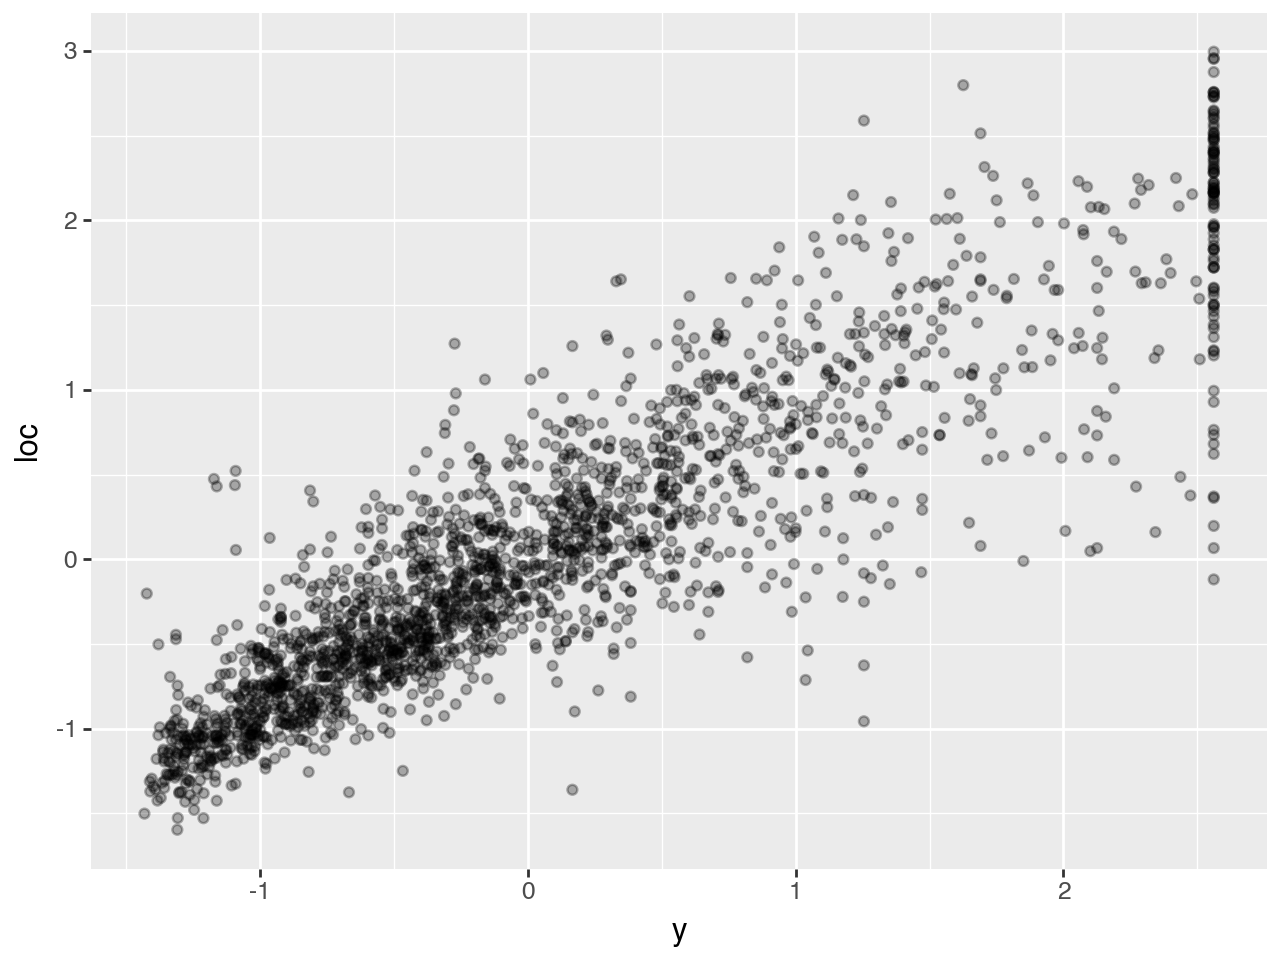

In [289]:
df_test = pd.DataFrame(test_prediction | {"y": data.test["y"]})
(p9.ggplot(df_test) + p9.aes("y", "loc") + p9.geom_point(alpha=0.3))

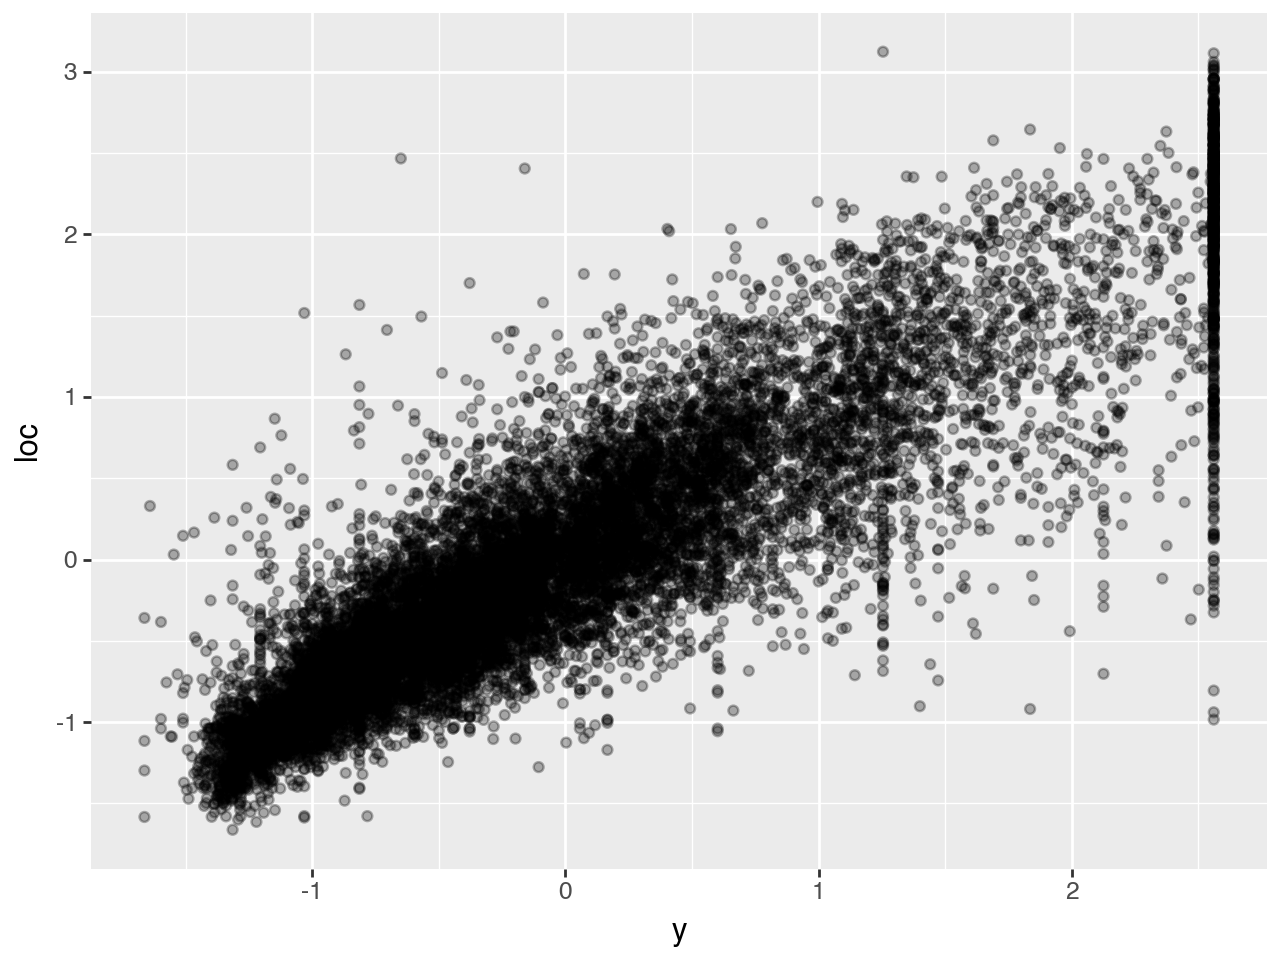

In [290]:
train_x = {k: v for k, v in data.train.items() if k != "y"}
train_prediction = model.predict(samples, predict=["loc", "scale"], newdata=train_x)
train_prediction = jax.tree.map(jnp.squeeze, train_prediction)
df_train = pd.DataFrame(train_prediction | {"y": data.train["y"]})
(p9.ggplot(df_train) + p9.aes("y", "loc") + p9.geom_point(alpha=0.3))

In [291]:
train_prediction = model.predict(samples, predict=["loc", "scale"], newdata=train_x)
train_prediction = jax.tree.map(jnp.squeeze, train_prediction)
df_train = pd.DataFrame(train_prediction | data.train)


In [292]:
df_train

,loc,scale,y,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.584573,0.46223795,1.408058,6.7974,33.0,5.992481,0.939850,385.0,2.894737,36.980000,-122.040001
1,0.091101,0.46223795,0.240322,5.3368,28.0,7.241559,0.961039,1140.0,2.961039,34.110001,-117.650002
2,-0.037987,0.46223795,-0.628732,2.7188,32.0,5.511628,1.067829,1337.0,2.591085,34.939999,-120.419998
3,0.078319,0.46223795,0.245547,2.5806,47.0,4.739057,1.143098,1533.0,2.580808,34.049999,-118.349998
4,0.311848,0.46223795,1.556964,3.2708,46.0,4.611607,0.995536,462.0,2.062500,33.529999,-117.769997
...,...,...,...,...,...,...,...,...,...,...,...
14443,0.453586,0.46223795,0.668753,5.3220,17.0,5.341041,1.028902,3008.0,2.897881,33.810001,-118.300003
14444,-1.239524,0.46223795,-1.255705,1.7292,31.0,5.298755,1.091286,600.0,2.489627,41.459999,-122.900002
14445,-0.800845,0.46223795,-0.734098,2.3314,29.0,4.879050,1.041037,1099.0,2.373650,38.740002,-120.809998
14446,-0.133720,0.46223795,-0.519883,1.7701,26.0,2.666082,1.098160,4812.0,4.217353,33.779999,-118.180000


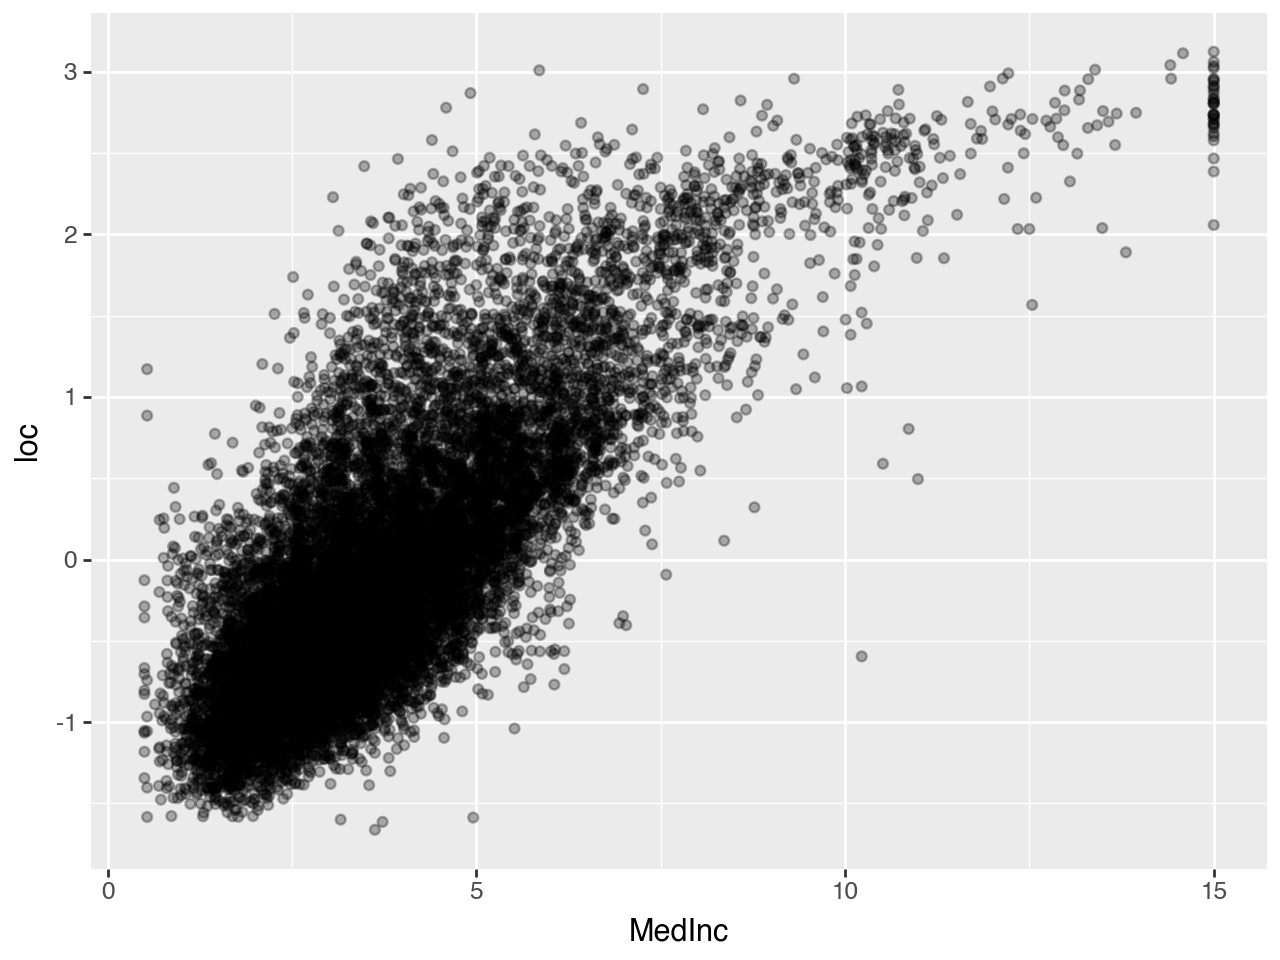

In [293]:
(p9.ggplot(df_train) + p9.aes("MedInc", "loc") + p9.geom_point(alpha=0.3))

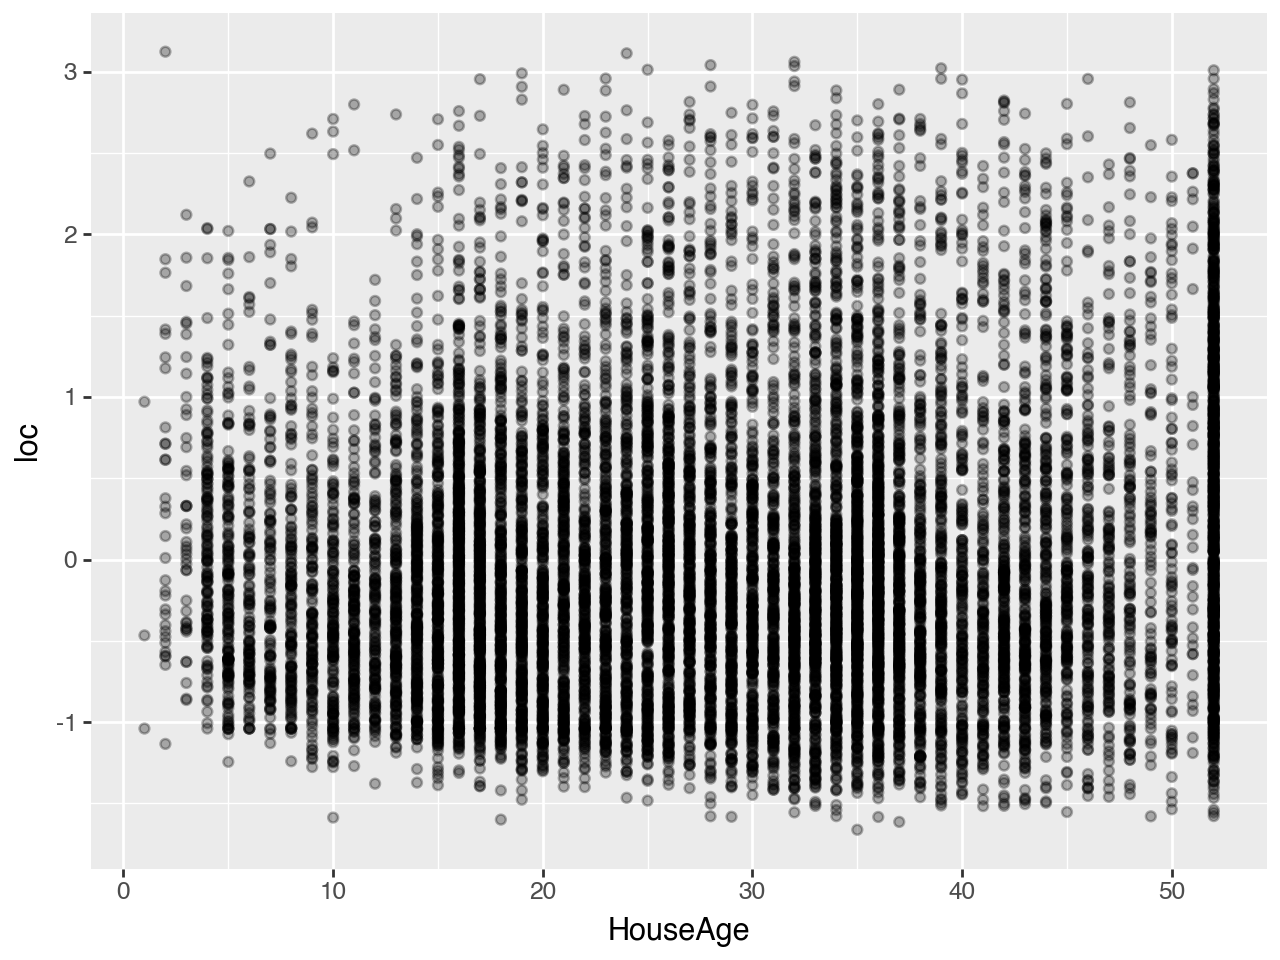

In [294]:
(p9.ggplot(df_train) + p9.aes("HouseAge", "loc") + p9.geom_point(alpha=0.3))

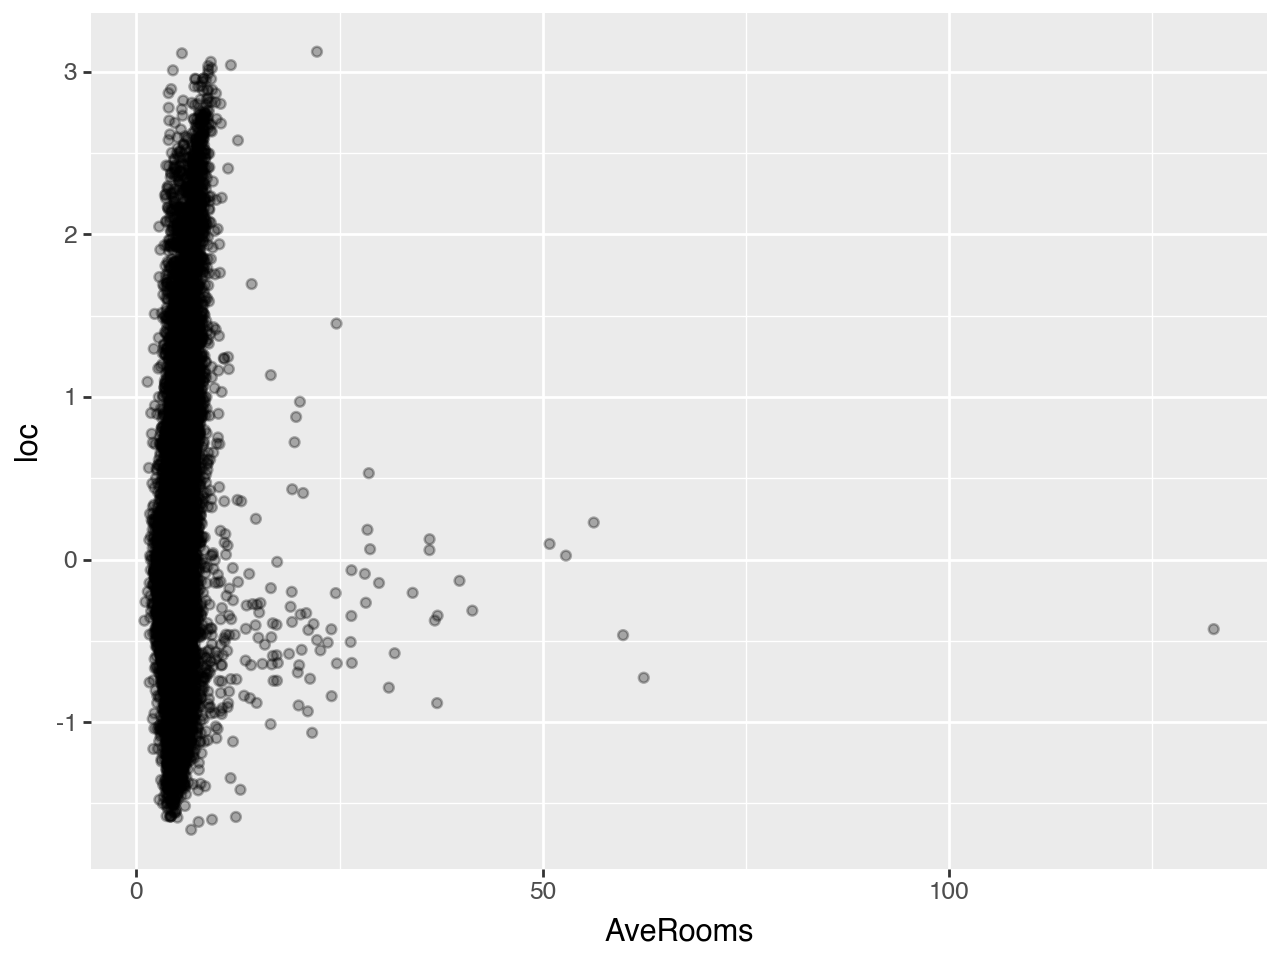

In [295]:
(p9.ggplot(df_train) + p9.aes("AveRooms", "loc") + p9.geom_point(alpha=0.3))

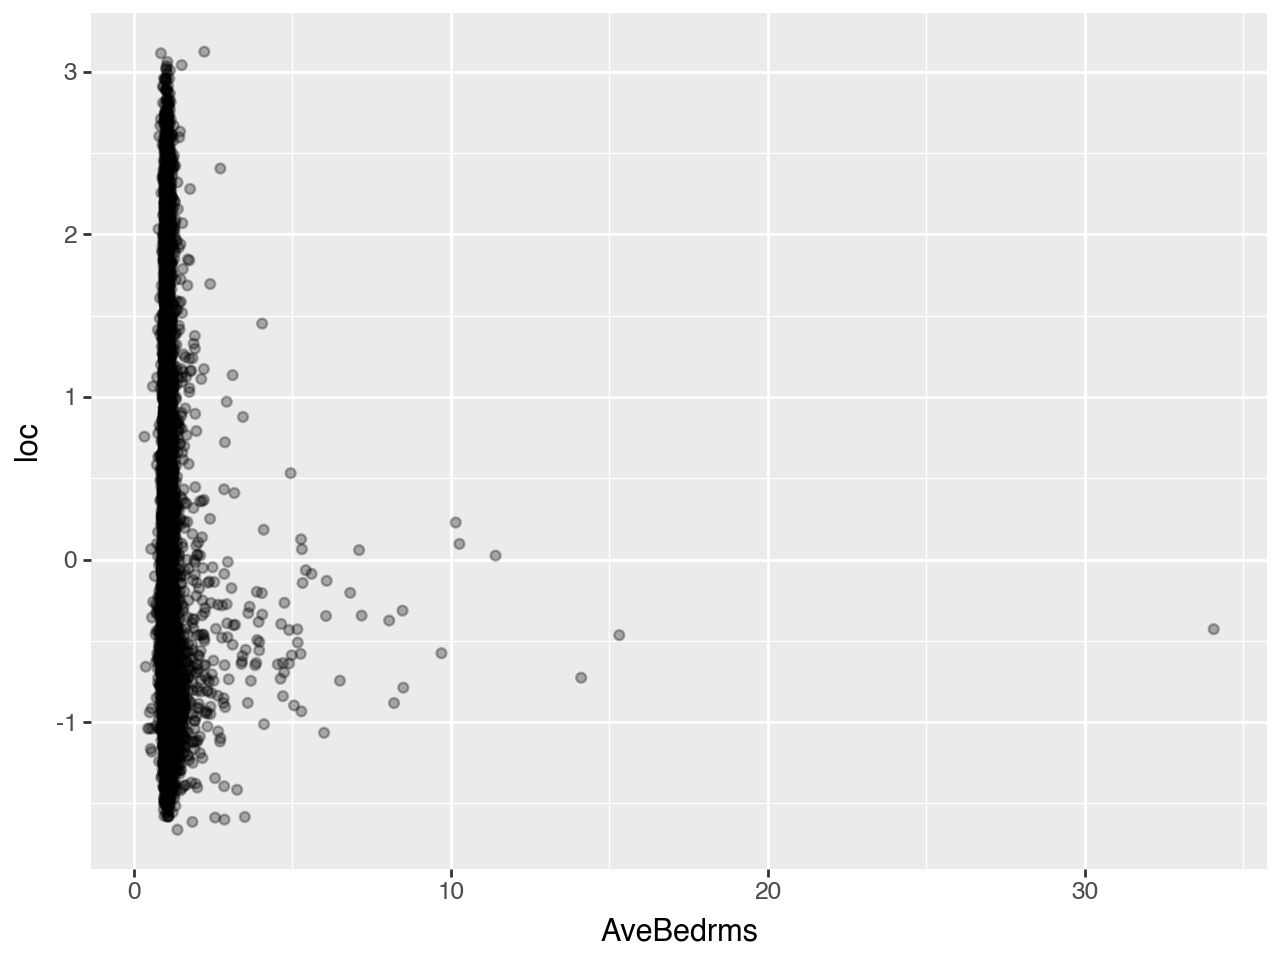

In [296]:
(p9.ggplot(df_train) + p9.aes("AveBedrms", "loc") + p9.geom_point(alpha=0.3))